In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt
from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as F

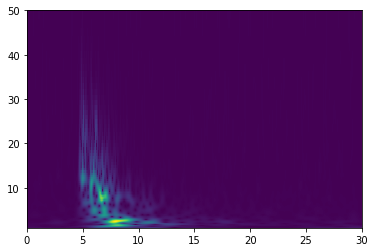

In [7]:

st = obspy.read()
tr = st[0] # 读取一个默认时间序列
npts = tr.stats.npts  # 一共有多长
dt = tr.stats.delta   # 因为采样频率是100Hz，所以间隔是0.01
t = np.linspace(0, dt * npts, npts)
f_min = 1
f_max = 50

scalogram = cwt(tr.data, dt, 8, f_min, f_max)


fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(
    t,
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)

ax.set_ylim(f_min, f_max)
plt.show()

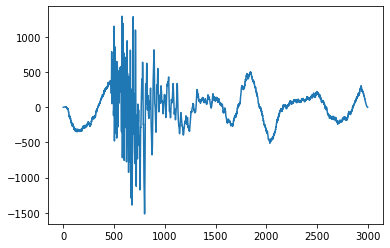

In [12]:
plt.plot(tr.data)

In [30]:
c_in = 3
fmax = 50
kernel = 3
length = 512

conv1d_dw = nn.Conv2d(in_channels = c_in,
                      out_channels = c_in,
                      kernel_size=[3, kernel], 
                      padding  = [0,1],
                      groups = c_in,
                      bias    =  False, 
                      #stride  = [1,4],
                      padding_mode="replicate"
                     )

input_ = torch.rand(1,c_in,fmax,length).float()
conv1d_dw(input_).shape

torch.Size([1, 3, 48, 128])

In [20]:
class depthweise_seperable_convolution(nn.Module):
    def __init__(self, c_in, c_out, 
                 kernel_size, 
                 stride=1, 
                 bias = False, padding_mode = "replicate"):
        
        super(depthweise_seperable_convolution, self).__init__()
        
        self.dw_conv = nn.Conv2d(in_channels  = c_in,
                                 out_channels = c_in,
                                 kernel_size  = [kernel_size,kernel_size],
                                 padding      = [0,int(kernel_size/2)],
                                 groups       = c_in,
                                 stride       = [1,stride],
                                 bias         = bias,  
                                 padding_mode = padding_mode)
        self.batch_norm_1 = nn.BatchNorm2d(c_in)
        self.act_1  = nn.ReLU()
        
        self.pw_conv = nn.Conv2d(in_channels  = c_in,
                                 out_channels = c_out,
                                 kernel_size  = 1,
                                 padding      = [0,0],
                                 stride       = 1,
                                 bias         = bias,  
                                 padding_mode = padding_mode)
        self.batch_norm_2 = nn.BatchNorm2d(c_out)
        self.act_2  = nn.ReLU()
        
    def forward(self, x):

        x  = self.dw_conv(x)
        x  = self.batch_norm_1(x)
        x  = self.act_1(x)

        x  = self.pw_conv(x)
        x  = self.batch_norm_2(x)
        x  = self.act_2(x)

        return x
c_in = 128
fmax = 20
kernel = 3
length = 512
op_1 = depthweise_seperable_convolution(c_in,64,3,stride=2)
op_2 = depthweise_seperable_convolution(64,32,3,stride=2)
op_3 = depthweise_seperable_convolution(32,4,3,stride=2)
op_4 = depthweise_seperable_convolution(4,1,3,stride=2)
input_ = torch.rand(2,c_in,fmax,length).float()
op_1(input_).shape
op_4(op_3(op_2(op_1(input_)))).shape

torch.Size([2, 1, 12, 32])

In [8]:
op.dw_conv.weight.shape

torch.Size([4, 1, 5, 5])

In [9]:
op.pw_conv.weight.shape

torch.Size([4, 4, 1, 1])

In [28]:
class_emb = nn.Parameter(torch.ones(1, 1, 10), requires_grad=True)
x = torch.zeros(1,100,10).float()
cls_token = class_emb.expand(x.shape[0], -1, -1)

In [29]:
class_emb

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], requires_grad=True)

In [30]:
cls_token

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<ExpandBackward>)

In [31]:
torch.cat((cls_token, x), dim=1)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<CatBackward>)

In [33]:
from einops import rearrange, repeat

In [34]:
class_emb = nn.Parameter(torch.ones(1, 1, 10), requires_grad=True)
x = torch.zeros(1,100,10).float()
b, n, _ = x.shape

cls_tokens = repeat(class_emb, '() n d -> b n d', b = b)

In [35]:
cls_tokens

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<ViewBackward>)

In [ ]:




st = obspy.read()
tr = st[0]
npts = tr.stats.npts
dt = tr.stats.delta
t = np.linspace(0, dt * npts, npts)
f_min = 1
f_max = 50

scalogram = cwt(tr.data, dt, 8, f_min, f_max)

fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(
    t,
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))
# t = np.linspace(0,  npts, npts)
# x, y = np.meshgrid(
#     t,
#     np.logspace(0, f_max, scalogram.shape[0]))
ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
#ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
#ax.set_ylabel("Frequency [Hz]")
#ax.set_yscale('log')
ax.set_ylim(f_min, f_max)
plt.show()